# Identifying Abnormal Rhythms on Electrocardiograms with Keras Tensorflow
### This example will train an autoencoder to identify abnormal rhythms on ECG5000 electrocardiograms dataset with Keras Tensorflow.
#### The full dataset contains 5,000 Electrocardiograms with 140 points each and was published in: Goldberger, A. L., Amaral, L. A. N., Glass, L., Hausdorff, J. M., Ivanov, P. Ch., Mark, R. G., Mietus, J. E., Moody, G. B., Peng, C.-K., & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation, 101(23), e215-e220. The full dataset may also be found here: https://www.timeseriesclassification.com/description.php?Dataset=ECG5000
#### The simplified version of the dataset is used for this example. The simplified version has been labeled either 1 (corresponding to a normal rhythm) or 0 (corresponding to an abnormal rhythm). The simplied dataset may be found here: http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv
#### This example focuses on identifying abnormal rhythms.

In [249]:
# Import the required libraries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pydot
import graphviz
from keras.utils import plot_model
from PIL import Image

# initialize the seeds of different random number generators, so the results will be the same. 
tf.random.set_seed(42)

# Pandas will suppress chained_assignment warnings. A chained assignment occurs when you try to assign a value to a DataFrame slice.
pd.options.mode.chained_assignment = None

### Next, we will import the dataset, available in CSV form to a Pandas dataframe, df. 
#### Each Column of the data represents a data point, so we will name the columns by the sequence of data points (i.e. 1,2,...,140)

In [250]:
# creates empty list, "names"
names = []

# for loop that iterates 140 times, with i taking values from 0 to 139.
# Appends the current value of i to the names list in each iteration. After this loop, names will contain numbers from 0 to 139.
for i in range(140):
    names.append(i)
# The last column will be the target or dependent variable. Appends the string 'Target' to the end of the names list.
names.append('Target')
print(names)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 'Target']


In [251]:
# Import simplified ECG dataset from tensorflow
# names = names will set the column names from the "names" list created above.
df = pd.read_csv("http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv", names = names)
print(('The shape of the dataframe is (rows, columns):'), df.shape)
print('The dataset has 4998 rows and 141 columns (140 independent variables + 1 dependent variable)')
print('\nHere are the first 10 rows:\n')
df.head(10)

The shape of the dataframe is (rows, columns): (4998, 141)
The dataset has 4998 rows and 141 columns (140 independent variables + 1 dependent variable)

Here are the first 10 rows:



,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,Target
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0
5,-1.507674,-3.574550,-4.478011,-4.408275,-3.321242,-2.105171,-1.481048,-1.301362,-0.498240,-0.286928,...,1.089068,0.983369,1.014124,0.952629,0.749326,1.007076,1.634990,1.493365,-0.783134,1.0
6,-0.297161,-2.766635,-4.102185,-4.589669,-4.219357,-3.650443,-2.300518,-1.293917,-1.065658,-0.490520,...,0.581779,0.684406,0.911651,0.979483,1.053458,0.974787,1.110407,1.288165,-0.823386,1.0
7,0.446769,-1.507397,-3.187468,-4.507462,-4.604201,-3.636115,-2.311604,-1.597727,-1.362450,-0.669216,...,1.001306,1.292059,1.378667,1.014765,0.820793,1.034388,1.258433,0.961215,-0.999476,1.0
8,0.087631,-1.753490,-3.304473,-4.704657,-4.686415,-3.611817,-2.267268,-1.570893,-1.417790,-0.500788,...,1.709046,2.142926,2.393528,1.925550,1.027624,0.573453,0.192971,-0.648683,-2.441068,1.0
9,-0.832281,-1.700368,-2.257301,-2.853671,-2.853301,-2.701487,-2.285726,-1.555512,-1.266622,-1.085957,...,2.110504,2.203668,2.227544,2.171733,2.045938,2.126372,2.126852,1.679299,0.965814,1.0


### Preprocessing the dataframe
#### The dependent variables, 'Target' will be extracted since the rest of the dataset only has numeric variables. 

In [252]:
numerics = names

# Remove the dependent variable
numerics.remove('Target')

### What Percentage of the data is Abnormal?

In [253]:
# Set "target_metrics" output to the percentage of abnormal data found in the 'Target' column
target_metrics = df.Target.value_counts(normalize=True)
print(target_metrics)

Target
1.0    0.584034
0.0    0.415966
Name: proportion, dtype: float64


### The dependent variables contained in the 'Target' will be extracted and set to 'y'

In [254]:
# Set dependent variables in 'Target' to 'y'
y = df.pop('Target')
print(y)

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
4993    0.0
4994    0.0
4995    0.0
4996    0.0
4997    0.0
Name: Target, Length: 4998, dtype: float64


### The total dataset df is split into 80% training and 20% test dataframes
#### The dataset is split before being normalized to ensure the training and test dataframes have equal distributions.

In [255]:
# The total dataset is split into 80% training and 20% test dataframes:
# X_train, X_test, y_train and y_test
# stratify=y ensures equal proportions of the classes in the target variable (y or 'Target') in both the training and testing dataframes.
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, stratify=y)

### The mean and standard deviation of the numeric variables are calculated for the training dataframe. 

In [256]:
# Means are assigned to "means" and standard deviations to "sd"
means = X_train[numerics].mean()
sd = X_train[numerics].std()
print(means)
print(sd)

0     -0.245187
1     -1.634429
2     -2.487521
3     -3.120247
4     -3.170600
         ...   
135   -0.763427
136   -0.838367
137   -0.645243
138   -0.489386
139   -0.707244
Length: 140, dtype: float64
0      1.146355
1      1.442980
2      1.385480
3      1.301434
4      1.098855
         ...   
135    2.095068
136    2.068225
137    1.869869
138    1.842711
139    1.413009
Length: 140, dtype: float64


### The training and test dataframes are normalized with the calculated means and standard deviations.

In [257]:
# Normalize X_train
X_train[numerics]= (X_train[numerics] - means)/sd

In [258]:
# Normalize X_test
X_test[numerics]= (X_test[numerics] - means)/sd

In [259]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
896,-0.508212,-0.919281,-1.136236,-1.044346,-0.853793,-1.010818,-1.026389,-0.094263,-0.015314,-0.188562,...,1.079447,1.007275,0.808125,0.560205,0.331620,0.220799,0.161089,0.160351,0.416954,-0.075610
4361,0.537834,0.726917,0.700853,0.513680,0.198430,-0.330104,-0.864763,-1.084917,-0.801786,-0.716334,...,-0.202634,-0.580360,-0.768210,-0.802403,-1.011131,-1.240318,-1.505131,-1.405706,-1.234469,-0.376807
685,-0.954338,-0.770364,-0.583871,-0.601836,-0.723018,-0.924113,-0.844950,-0.279568,-0.328291,-0.385658,...,1.103150,0.791091,0.443843,0.056212,-0.175175,-0.306639,-0.219090,-0.054353,0.108443,-0.269782
3708,-0.262425,0.141568,0.419447,0.409678,0.290459,-0.031135,-0.716100,-1.054123,-1.123846,-1.168345,...,-1.617779,-1.596278,-1.521564,-1.433140,-1.309503,-1.170723,-0.904514,-0.615791,-0.277519,0.702371
4332,1.099708,1.156003,1.271639,1.048086,0.538462,-0.246293,-1.229382,-1.900846,-1.875601,-1.769496,...,-0.442854,-0.671823,-0.830334,-0.914170,-0.908517,-1.166394,-1.382905,-1.363754,-1.424777,-0.144841


### We convert X_train and X_test dataframes to Numpy arrays because this is an easy way to input Keras/Tensorflow data.

In [260]:
# Convert X_train and X_test to Numpy arrays
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

In [261]:
# Check the shapes of the training dataframes (X_train and y_train)
X_train.shape, y_train.shape

((3998, 140), (3998,))

In [262]:
# Check the shapes of the testing dataframes (X_test and y_test)
X_test.shape, y_test.shape

((1000, 140), (1000,))

## Build a Neural Network Model in Keras Tensorflow
#### The neural network will contain one hidden layer.
#### A sigmoid activation function will be used in the output layer since this is a binary classification problem.

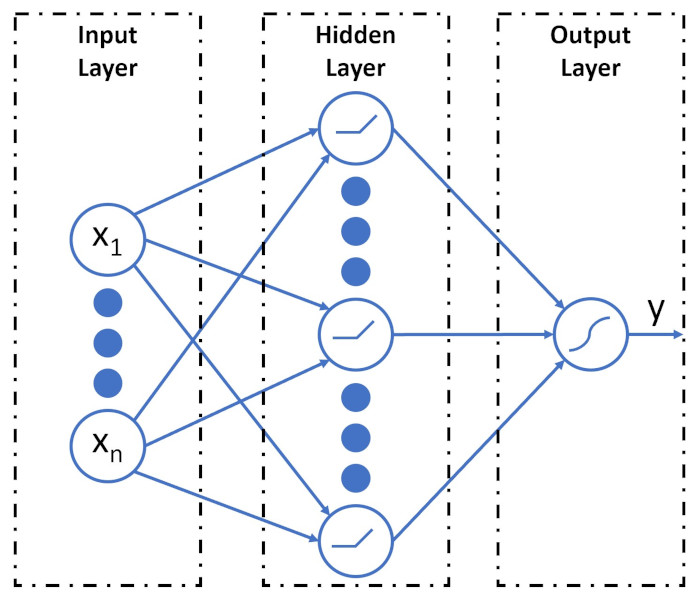

In [263]:
# Number of columns
num_columns = X_train.shape[1]

# Input layer ("input") is defined
#input = keras.Input(shape=num_columns)
# Input layer ("input") is defined
input = keras.Input(shape=(num_columns,))  # Pass num_columns as a tuple

# The input vector is fed into the hidden layer ("h").
h = keras.layers.Dense(16, activation="relu", name="Hidden")(input)

# The output of the hidden layer is run through a sigmoid activation function. 
output = keras.layers.Dense(1, activation="sigmoid", name="Output")(h)

# The Keras model (input,output) pair for your model. 
model = keras.Model(input,output)

In [264]:
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 140)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden (Dense)                  │ (None, 16)             │         2,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,273 (8.88 KB)

 Trainable params: 2,273 (8.88 KB)

 Non-trainable params: 0 (0.00 B)

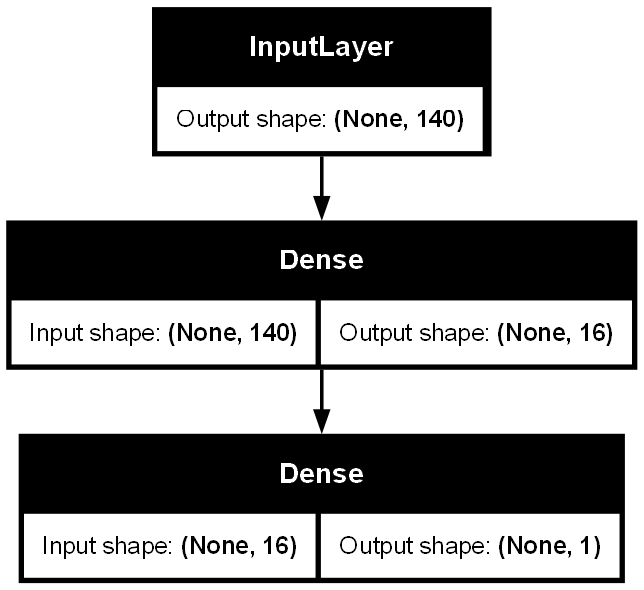

In [265]:
keras.utils.plot_model(model, show_shapes=True, dpi=128)

### Set Neural Network Optimization Parameters
#### The model was defined in the previous step but we still need to provide Keras:
##### Optimizer - Adam is selected as a default which is an SGD flavor
##### Loss Function - The model's output is binary, so binary_crossentropy is selected.
##### Metrics - This is a classifcation problem, so Accuracy is selected.

In [266]:
# Compile the model with the adam optimizer, binary crossentropy loss function, and accuracy metrics.
model.compile(optimizer="adam",
             loss="binary_crossentropy",
             metrics=["accuracy"])

### Train the Model on the Training Dataset
#### Training the model on the training dataset requires these items set:
##### The batch size - 32 is a good default
##### Number of epochs i.e. how many passes through the training data. The default starting setting for this exercise is 100 but can be optimized.
##### 20% of the data will be used as a validation dataset. Validation data can be useful for overfitting detection and regularization by early stopping. Early stopping can be completed by identifying the number of epochs where accuracy levels off. 

In [267]:
# Fitting the model and setting it to history
history = model.fit(X_train,
                   y_train,
                   epochs=100,
                   batch_size=32,
                   validation_split=0.2)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9447 - loss: 0.1724 - val_accuracy: 0.9862 - val_loss: 0.0429
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9912 - loss: 0.0346 - val_accuracy: 0.9912 - val_loss: 0.0322
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9948 - loss: 0.0251 - val_accuracy: 0.9912 - val_loss: 0.0295
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - accuracy: 0.9945 - loss: 0.0221 - val_accuracy: 0.9937 - val_loss: 0.0275
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9952 - loss: 0.0202 - val_accuracy: 0.9950 - val_loss: 0.0266
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9952 - loss: 0.0188 - val_accuracy: 0.9950 - val_loss: 0.0259
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - accuracy: 0.9955 - loss: 0.0175 - val_accuracy: 0.9937 - val_loss: 0.0257
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9956 - loss: 0.0161 - val_

### The training and loss curves are plotted to check for overfitting and if early stopping should be applied.

In [268]:
# Check to verify which keys were tracked while the neural network as solved
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

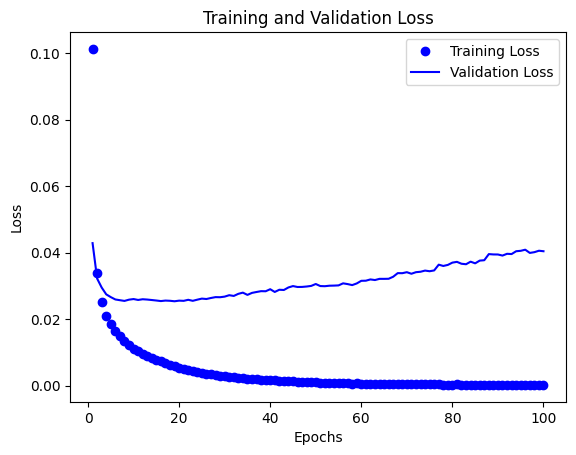

In [269]:
# loss values from the history_dict 
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
# Plot epochs vs loss_values
plt.plot(epochs, loss_values, "bo", label="Training Loss")
# Plot epochs vs val_loss_values
plt.plot(epochs, val_loss_values, "b", label="Validation Loss")
# Set plot title, x and y labels, show legend, and plot
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Plotting the Accuracy Curve

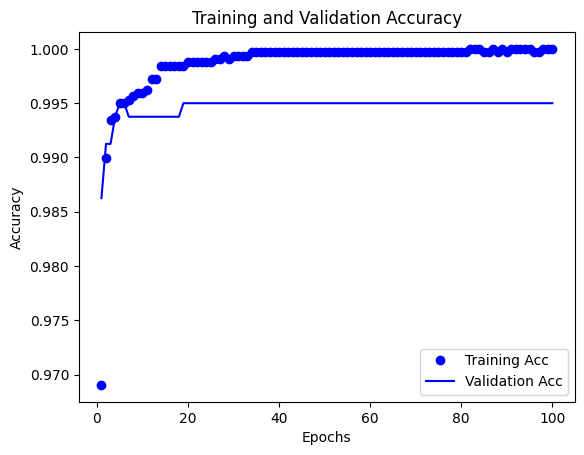

In [270]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training Acc")
plt.plot(epochs, val_acc, "b", label="Validation Acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### The plots are inspected to see if there is overfitting.
#### If we suspect there is overfitting at a specific epoch N, then the model can be reinitialize for that number, N epochs.
#### Specifying the number of epochs before overfitting occurs is called early stopping. The test accuracy below can be compared to determine which model is better. 

### Evaluate the Model on the Test Dataset
#### model.evaluate is a useful function to calculate the performance of the model on a dataset.

In [271]:
# Get the results of the model:
score, acc = model.evaluate(X_test, y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step - accuracy: 0.9893 - loss: 0.0798   


### Compare the Accuracy to a Baseline Model (simple) to Assess Accuracy Value.

In [272]:
# The percentages of each 1 and 0 in a simple baseline model of just always predicting 0. 
y.value_counts(normalize=True)

Target
1.0    0.584034
0.0    0.415966
Name: proportion, dtype: float64

### If 0 is predicted for every point, the baseline model accuracy is 41%.
### The accuracy is 58% if we always predict 1 for a baseline model.
### The neural network accuracy is 98.9% with 100 epochs.